# ==================================================
# S2 (Direct-Recursive Strategy)
# M1 (XGB)
# Standard Code _ Version 2.5 / KISLAB @ Kookmin University
# ==================================================

# Load Library

In [14]:
# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Regression
from xgboost import XGBRegressor

# Evaluation metrics for regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import joblib
import tensorflow as tf

import datetime
import sys

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import keras

# Basic Options (for Extended Experiment)

In [49]:
# 기본 설정값
SMCODE = "PAPER"    # S2(Direct-Recursive Strategy) + M1을 위한 Standard Code
PDCODE = "PEP"     # 품종코드
MDCODE = "XGB"     # 모델코드
PDNAME = "Pepper"   # 품종명(영문)
VARS = 1           # 확장변수 사용여부 (1: 가격만 사용, 2: 거래량 추가사용)

# Special Option 설정
IRANGE = 365   # 가격 데이터를 입력으로 사용할 때 최대 총 며칠치 데이터를 사용할 것인지에 대한 옵션
             # Feature Engineering을 적용하기 위해서는 반드시 IRANGE >= 365 이어야함
SPLIT = 0      # 이 값을 0으로 설정할 경우, validation 수행하지 않음
WINSOR = 10   # 이상치 제거를 위한 Winsorizing 기준 설정 (단위: 퍼센트 / 이 값이 0일 경우, 이상치 제거 안함)

# 검증기간 설정
TEST_PERIOD = 1       # 1을 입력하면 D1으로 기간이 설정되고, 2로 지정하면 D2로 기간 설정

if TEST_PERIOD == 1:
    BASEDATE = '2021-01-01'   # 검증용 데이터의 시작 시점 (D1을 위한 설정)
    USEDATE = '2021-12-31'    # 전체 사용할 데이터의 마지막 시점 (D1을 위한 설정)
elif TEST_PERIOD == 2:
    BASEDATE = '2022-01-01'   # 검증용 데이터의 시작 시점 (D2를 위한 설정)
    USEDATE = '2022-07-31'    # 전체 사용할 데이터의 마지막 시점 (D2를 위한 설정)
elif TEST_PERIOD == 3:
    BASEDATE = '2022-08-31'
    USEDATE = '2022-08-31'

SELECTED = [7, 30, 60, 90]        # 예측모델을 개발할 선택 시점
NSEL = len(SELECTED)    # 예측모델을 개발할 선택 시점의 총 갯수


# ========= 결과 저장용 폴더 생성 ==============

# System related and data input controls
import os

MODEL_DIR = 'MODEL_' + PDCODE + '_' + SMCODE + 'V' + str(VARS) + '_' + MDCODE
SCALE_DIR = 'SCALE_' + PDCODE + '_' + SMCODE + 'V' + str(VARS) + '_' + MDCODE

if os.path.exists(MODEL_DIR) == False:
    os.mkdir(f'{MODEL_DIR}')

if os.path.exists(SCALE_DIR) == False:
    os.mkdir(f'{SCALE_DIR}')

# ============= 데이터셋 로드 ================

# Ignore the warnings
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd

#load data
raw = pd.read_excel('(140103-220831)풋고추(청양).xlsx', usecols=['일자', '품종', '거래량(톤)', '도매가격(원/kg)'])
# raw = raw[raw['품종']=='양파(일반)']

#create 'datetime' column
if '일자' in raw.columns:
    raw['일자'] = pd.to_datetime(raw['일자'])
    raw['DateTime'] = pd.to_datetime(raw['일자'])

#set datetime to index
if raw.index.dtype == 'int64':
    raw.set_index('DateTime',inplace=True)

raw.drop (['품종', '일자'], axis=1, inplace=True)
raw.columns = ['Price', 'Volume']
# for i in range(0, raw.shape[0]):
#     raw['Volume'][i] = raw['Volume'][i].replace(',','')
# raw['Volume'] = raw['Volume'].astype('float32')

#fill missing date & values
raw.asfreq('D')[raw.asfreq('D').isnull().sum(axis=1) > 0]
raw = raw.asfreq('D', method='ffill')

# Data Partitioning

In [50]:
# Raw dataset selection
raw=raw[raw.index <= USEDATE]

# Train,Test split
test=raw[raw.index >= BASEDATE]
train=raw[raw.index < BASEDATE]
raw_idx = raw.index
train_idx = train.index

y_test = test['Price']

# XGB without FE / Training

In [51]:
VERBOSE = 1


with tf.device("/device:GPU:0"):

    train_price = raw.drop(['Volume'], axis=1)
    train_volume = raw.drop(['Price'], axis=1)

    # Price에 Outlier Treatment 적용 ---------------------#

    winsor_list = []
    winsor_list.append(WINSOR)
    winsor_list.append(100 - WINSOR)

    winsors = np.percentile(train_price['Price'][train_price.index < BASEDATE], winsor_list)
    winsor_min = winsors[0]
    winsor_max = winsors[1]

    train_price['Price'][train_price.index < BASEDATE] = np.where(train_price['Price'][train_price.index < BASEDATE] < winsor_min, winsor_min, train_price['Price'][train_price.index < BASEDATE])
    train_price['Price'][train_price.index < BASEDATE] = np.where(train_price['Price'][train_price.index < BASEDATE] > winsor_max, winsor_max, train_price['Price'][train_price.index < BASEDATE])

    #-----------------------------------------------------#

    for i in range(1, IRANGE + 1):
        train_price[f'Price_{i}lag'] = train_price['Price'].shift(i)
        train_volume[f'Volume_{i}lag'] = train_volume['Volume'].shift(i)
    

    for day_num in tqdm(range(1, 1 + max(SELECTED))):

        if day_num > 1 and day_num <= IRANGE+1:
            # lag 변수가 남아있는 상황이므로, lag변수 이동 및 예측값 대체가 필요

            # 대상이 될 lag변수 삭제
            train_price = train_price.drop([f'Price_{day_num-1}lag'], axis=1)

            # 기존 pred변수 하루 이전 값을 참조하도록 이동 (day_num >= 3 일 때부터 필요, 1일차에는 lag변수만 사용되고, 2일차에는 새로 들어올 pred만 하루 이전을 참조하게 조정하면 되므로)
            if day_num >= 3:
                for mov_pred in range(1, day_num-2):
                    train_price[f'Price_{mov_pred}pred'] = train_price[f'Price_{mov_pred}pred'].shift(1)

            # 새로 삽입될 pred변수가 하루 이전 값을 참조하도록 이동
            y_train_pred['pred'] = y_train_pred['pred'].shift(1)

            # train_price에 이전 모델의 예측결과를 위치 조정하여 추가삽입        
            train_price = pd.concat([y_train_pred, train_price], axis=1)

            # 열의 순서를 Price, 최근 Prediction result, 나머지 남아있는 변수들 순서로 조정
            cols = train_price.columns.tolist()
            cols = cols[1:2] + cols[0:1] + cols[2:]

            # pred로 되어 있는 임시 변수명을 model번호에 맞춰 이름 변경
            train_price = train_price[cols]
            train_price.rename(columns={'pred':f'Price_{day_num-1}pred'}, inplace=True)


            if VARS == 2:            # 거래량을 추가로 사용하는 경우

                train_volume = train_volume.drop([f'Volume_{day_num-1}lag'], axis=1)

                if day_num >= 3:
                    for mov_pred in range(1, day_num-2):
                        train_volume[f'Volume_{mov_pred}pred'] = train_volume[f'Volume_{mov_pred}pred'].shift(1)

                y_train_pred_vol['pred'] = y_train_pred_vol['pred'].shift(1)

                train_volume = pd.concat([y_train_pred_vol, train_volume], axis=1)

                # 열의 순서를 Volume, 최근 Prediction result, 나머지 남아있는 변수들 순서로 조정
                cols = train_volume.columns.tolist()
                cols = cols[1:2] + cols[0:1] + cols[2:]

                # pred로 되어 있는 임시 변수명을 model번호에 맞춰 이름 변경
                train_volume = train_volume[cols]
                train_volume.rename(columns={'pred':f'Volume_{day_num-1}pred'}, inplace=True)


        elif day_num > IRANGE+1:
            # lag 변수가 남아있지 않은 상황이므로, 예측값 대체만 진행

            # 마지막 pred 변수 삭제
            train_price = train_price.drop([f'Price_{day_num-IRANGE-1}pred'], axis=1)

            # 기존 pred변수 하루 이전 값을 참조하도록 이동
            for mov_pred in range(day_num-IRANGE, day_num-1):
                train_price[f'Price_{mov_pred}pred'] = train_price[f'Price_{mov_pred}pred'].shift(1)

            # 새로 삽입될 pred변수가 하루 이전 값을 참조하도록 이동
            y_train_pred['pred'] = y_train_pred['pred'].shift(1)

            # train_price에 이전 모델의 예측결과를 위치 조정하여 추가삽입        
            train_price = pd.concat([y_train_pred, train_price], axis=1)

            # 열의 순서를 Price, 최근 Prediction result, 나머지 남아있는 변수들 순서로 조정
            cols = train_price.columns.tolist()
            cols = cols[1:2] + cols[0:1] + cols[2:]

            # pred로 되어 있는 임시 변수명을 model번호에 맞춰 이름 변경
            train_price = train_price[cols]
            train_price.rename(columns={'pred':f'Price_{day_num-1}pred'}, inplace=True) 


            if VARS == 2:            # 거래량을 추가로 사용하는 경우

                train_volume = train_volume.drop([f'Volume_{day_num-IRANGE-1}pred'], axis=1)

                for mov_pred in range(day_num-IRANGE, day_num-1):
                    train_volume[f'Volume_{mov_pred}pred'] = train_volume[f'Volume_{mov_pred}pred'].shift(1)

                y_train_pred_vol['pred'] = y_train_pred_vol['pred'].shift(1)

                train_volume = pd.concat([y_train_pred_vol, train_volume], axis=1)

                # 열의 순서를 Volume, 최근 Prediction result, 나머지 남아있는 변수들 순서로 조정
                cols = train_volume.columns.tolist()
                cols = cols[1:2] + cols[0:1] + cols[2:]

                # pred로 되어 있는 임시 변수명을 model번호에 맞춰 이름 변경
                train_volume = train_volume[cols]
                train_volume.rename(columns={'pred':f'Volume_{day_num-1}pred'}, inplace=True)

        if VARS == 2:            # 거래량을 추가로 사용하는 경우

            train_volume_selected = train_volume.drop(['Volume'], axis=1)    # Volume의 시계열 정보만 선택
            train_price_final = pd.concat([train_price, train_volume_selected], axis=1)   # Price와 Volume 정보 결함
            train_price_final = train_price_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

        else:

            train_price_final = train_price.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외


        train_new = train_price_final[train_price_final.index <= BASEDATE]
#         test_new = train_price_final[train_price_final.index >= BASEDATE]

        y_train_raw = train_new['Price']
        x_train_raw = train_new.drop(['Price'],axis=1)   

        # Min-Max Normalization 적용
        scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
        X_train = scaler_X_tr.fit_transform(x_train_raw)

        joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.save')                    

         # Validation 데이터을 학습에 사용할 경우에 대한 처리        

        if SPLIT == 0:
            x_train = X_train
            y_train = y_train_raw
        else:
            x_train = X_train[:-SPLIT]
            y_train = y_train_raw[:-SPLIT]
            x_valid = X_train[-SPLIT:]
            y_valid = y_train_raw[-SPLIT:]
            

        # XGB Training
        params_xgb = {
            'max_depth':4,
                      # 'learning_rate':0.05,
        #               'subsample':0.8,
        #               'colsample_bytree':0.6,
        #               'eval_metric':'logloss',
        #               'object': 'reg:squarederror',
        #               'tree_method':'gpu_hist',
        #               'predictor':'gpu_predictor',
                      'num_leaves': 555,
          # 'min_child_weight': 0.034,
          # 'feature_fraction': 0.379,
          # 'bagging_fraction': 0.418,
          # 'min_data_in_leaf': 106,
          # 'objective': 'regression',
          # 'max_depth': -1,
          'learning_rate': 0.05,
          # "boosting_type": "gbdt",
          # "bagging_seed": 11,
          # "metric": 'rmse',
          # "verbose": -1,
          # 'reg_alpha': 0.3899,
          # 'reg_lambda': 0.648,
          # 'random_state': 222,

                      }  

        xgb_model = XGBRegressor(
            **params_xgb
            , random_state=222
        )
        if SPLIT == 0:
            model = xgb_model.fit(x_train, y_train)
        else:
            model = xgb_model.fit(x_train, y_train, eval_set=(x_valid, y_valid), use_best_model=True, verbose=False)

        # Save model
        joblib.dump(model,f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.pkl')         

        # Prediction
        Y_train_pred = model.predict(X_train)

        y_train_pred = pd.DataFrame(columns=['pred'],index=x_train_raw.index)
        y_train_pred['pred'] = Y_train_pred   # 날짜 인덱스를 추가하여 y_train_pred에 pred라는 열로 값 저장


        if VARS == 2:

            train_volume_final = train_volume.dropna(axis=0)

            train_new = train_volume_final[train_volume_final.index < BASEDATE]
            test_new = train_volume_final[train_volume_final.index >= BASEDATE]

            y_train_raw = train_new['Volume']
            x_train_raw = train_new.drop(['Volume'],axis=1)   

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)

            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}(VOL).save')                    

             # Validation 데이터을 학습에 사용할 경우에 대한 처리

            if SPLIT == 0:
                x_train = X_train
                y_train = y_train_raw
            else:
                x_train = X_train[:-SPLIT]
                y_train = y_train_raw[:-SPLIT]
                x_valid = X_train[-SPLIT:]
                y_valid = y_train_raw[-SPLIT:]
            

            # XGB Training

            params_xgb = {'object': 'reg:squarederror',
                          'n_estimators': 10,                 
                          'learning_rate': 0.02,
                          'max_depth': 20,
                          'eval_metric':'rmse',
                          'subsample':'0.75',
                          'colsample_bytree':1,
                          'gamma':0.25,
                          'verbosity':0,
                          'booster': 'gbtree',
                          'mthread':16,
                          'n_jobs':-1
                          }  

            xgb_model = XGBRegressor(**params_xgb, random_state=44)

            if SPLIT == 0:
                model = xgb_model.fit(x_train, y_train)
            else:
                model = xgb_model.fit(x_train, y_train, eval_set=(x_valid, y_valid), use_best_model=True, verbose=False)

            # Save model
            joblib.dump(model,f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}_VOL.pkl')   

            # Prediction
            Y_train_pred_vol = model.predict(X_train)

            y_train_pred_vol = pd.DataFrame(columns=['pred'],index=x_train_raw.index)
            y_train_pred_vol['pred'] = Y_train_pred_vol   # 날짜 인덱스를 추가하여 y_train_pred에 pred라는 열로 값 저장    

  0%|          | 0/90 [00:00<?, ?it/s]

[09:57:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  1%|          | 1/90 [00:00<01:13,  1.21it/s]

[09:57:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  2%|▏         | 2/90 [00:01<01:22,  1.06it/s]

[09:57:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  3%|▎         | 3/90 [00:02<01:19,  1.10it/s]

[09:57:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  4%|▍         | 4/90 [00:03<01:15,  1.14it/s]

[09:57:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  6%|▌         | 5/90 [00:04<01:11,  1.19it/s]

[09:57:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  7%|▋         | 6/90 [00:05<01:09,  1.21it/s]

[09:57:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  8%|▊         | 7/90 [00:05<01:06,  1.24it/s]

[09:57:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




  9%|▉         | 8/90 [00:06<01:04,  1.26it/s]

[09:57:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 10%|█         | 9/90 [00:07<01:02,  1.29it/s]

[09:57:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 11%|█         | 10/90 [00:08<01:02,  1.27it/s]

[09:57:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 12%|█▏        | 11/90 [00:09<01:07,  1.17it/s]

[09:57:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 13%|█▎        | 12/90 [00:10<01:06,  1.17it/s]

[09:57:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 14%|█▍        | 13/90 [00:10<01:03,  1.22it/s]

[09:57:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 16%|█▌        | 14/90 [00:11<01:00,  1.26it/s]

[09:57:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 17%|█▋        | 15/90 [00:12<00:59,  1.27it/s]

[09:57:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 18%|█▊        | 16/90 [00:13<00:57,  1.28it/s]

[09:57:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 19%|█▉        | 17/90 [00:13<00:56,  1.30it/s]

[09:57:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 20%|██        | 18/90 [00:14<00:56,  1.28it/s]

[09:57:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 21%|██        | 19/90 [00:15<00:54,  1.30it/s]

[09:57:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 22%|██▏       | 20/90 [00:16<00:53,  1.30it/s]

[09:57:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 23%|██▎       | 21/90 [00:16<00:52,  1.32it/s]

[09:57:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 24%|██▍       | 22/90 [00:17<00:52,  1.31it/s]

[09:57:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 26%|██▌       | 23/90 [00:18<00:51,  1.30it/s]

[09:57:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 27%|██▋       | 24/90 [00:19<00:50,  1.31it/s]

[09:57:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 28%|██▊       | 25/90 [00:19<00:49,  1.32it/s]

[09:57:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 29%|██▉       | 26/90 [00:20<00:49,  1.28it/s]

[09:57:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 30%|███       | 27/90 [00:21<00:48,  1.30it/s]

[09:57:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 31%|███       | 28/90 [00:22<00:48,  1.27it/s]

[09:57:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 32%|███▏      | 29/90 [00:23<00:49,  1.24it/s]

[09:57:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 33%|███▎      | 30/90 [00:24<00:48,  1.23it/s]

[09:57:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 34%|███▍      | 31/90 [00:24<00:48,  1.21it/s]

[09:57:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 36%|███▌      | 32/90 [00:25<00:48,  1.19it/s]

[09:57:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 37%|███▋      | 33/90 [00:26<00:53,  1.06it/s]

[09:57:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 38%|███▊      | 34/90 [00:27<00:52,  1.07it/s]

[09:57:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 39%|███▉      | 35/90 [00:28<00:50,  1.09it/s]

[09:57:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 40%|████      | 36/90 [00:29<00:50,  1.07it/s]

[09:57:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 41%|████      | 37/90 [00:30<00:54,  1.02s/it]

[09:57:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 42%|████▏     | 38/90 [00:31<00:52,  1.00s/it]

[09:57:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 43%|████▎     | 39/90 [00:32<00:49,  1.03it/s]

[09:57:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 44%|████▍     | 40/90 [00:33<00:47,  1.06it/s]

[09:57:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 46%|████▌     | 41/90 [00:34<00:44,  1.09it/s]

[09:57:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 47%|████▋     | 42/90 [00:35<00:43,  1.11it/s]

[09:57:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 48%|████▊     | 43/90 [00:36<00:42,  1.12it/s]

[09:57:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 49%|████▉     | 44/90 [00:37<00:40,  1.13it/s]

[09:57:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 50%|█████     | 45/90 [00:37<00:39,  1.14it/s]

[09:57:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 51%|█████     | 46/90 [00:38<00:38,  1.14it/s]

[09:57:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 52%|█████▏    | 47/90 [00:39<00:37,  1.15it/s]

[09:57:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 53%|█████▎    | 48/90 [00:40<00:36,  1.15it/s]

[09:57:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 54%|█████▍    | 49/90 [00:41<00:35,  1.16it/s]

[09:57:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 56%|█████▌    | 50/90 [00:42<00:34,  1.16it/s]

[09:57:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 57%|█████▋    | 51/90 [00:43<00:33,  1.17it/s]

[09:57:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 58%|█████▊    | 52/90 [00:43<00:32,  1.17it/s]

[09:57:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 59%|█████▉    | 53/90 [00:44<00:31,  1.16it/s]

[09:57:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 60%|██████    | 54/90 [00:45<00:30,  1.16it/s]

[09:58:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 61%|██████    | 55/90 [00:46<00:30,  1.15it/s]

[09:58:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 62%|██████▏   | 56/90 [00:47<00:29,  1.15it/s]

[09:58:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 63%|██████▎   | 57/90 [00:48<00:28,  1.15it/s]

[09:58:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 64%|██████▍   | 58/90 [00:49<00:27,  1.15it/s]

[09:58:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 66%|██████▌   | 59/90 [00:50<00:26,  1.15it/s]

[09:58:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 67%|██████▋   | 60/90 [00:50<00:26,  1.15it/s]

[09:58:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 68%|██████▊   | 61/90 [00:51<00:25,  1.16it/s]

[09:58:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 69%|██████▉   | 62/90 [00:52<00:24,  1.16it/s]

[09:58:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 70%|███████   | 63/90 [00:53<00:23,  1.16it/s]

[09:58:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 71%|███████   | 64/90 [00:54<00:22,  1.16it/s]

[09:58:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 72%|███████▏  | 65/90 [00:55<00:21,  1.16it/s]

[09:58:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 73%|███████▎  | 66/90 [00:56<00:20,  1.16it/s]

[09:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 74%|███████▍  | 67/90 [00:56<00:19,  1.16it/s]

[09:58:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 76%|███████▌  | 68/90 [00:57<00:18,  1.16it/s]

[09:58:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 77%|███████▋  | 69/90 [00:58<00:18,  1.16it/s]

[09:58:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 78%|███████▊  | 70/90 [00:59<00:17,  1.16it/s]

[09:58:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 79%|███████▉  | 71/90 [01:00<00:16,  1.16it/s]

[09:58:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 80%|████████  | 72/90 [01:01<00:15,  1.16it/s]

[09:58:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 81%|████████  | 73/90 [01:02<00:14,  1.16it/s]

[09:58:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 82%|████████▏ | 74/90 [01:02<00:13,  1.16it/s]

[09:58:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 83%|████████▎ | 75/90 [01:03<00:12,  1.16it/s]

[09:58:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 84%|████████▍ | 76/90 [01:04<00:12,  1.15it/s]

[09:58:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 86%|████████▌ | 77/90 [01:05<00:11,  1.15it/s]

[09:58:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 87%|████████▋ | 78/90 [01:06<00:10,  1.16it/s]

[09:58:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 88%|████████▊ | 79/90 [01:07<00:09,  1.14it/s]

[09:58:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 89%|████████▉ | 80/90 [01:08<00:08,  1.14it/s]

[09:58:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 90%|█████████ | 81/90 [01:09<00:07,  1.14it/s]

[09:58:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 91%|█████████ | 82/90 [01:09<00:07,  1.14it/s]

[09:58:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 92%|█████████▏| 83/90 [01:10<00:06,  1.15it/s]

[09:58:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 93%|█████████▎| 84/90 [01:11<00:05,  1.15it/s]

[09:58:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 94%|█████████▍| 85/90 [01:12<00:04,  1.15it/s]

[09:58:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 96%|█████████▌| 86/90 [01:13<00:03,  1.15it/s]

[09:58:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 97%|█████████▋| 87/90 [01:14<00:02,  1.15it/s]

[09:58:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 98%|█████████▊| 88/90 [01:15<00:01,  1.15it/s]

[09:58:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 99%|█████████▉| 89/90 [01:16<00:00,  1.15it/s]

[09:58:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████| 90/90 [01:16<00:00,  1.17it/s]


# XGB without FE / Inference

In [52]:
import datetime
print(datetime.datetime.now())

pred = []
DCNT = test.shape[0]

scaler = []
load_model = []

scaler_vol = []
load_model_vol = []


pos = 0

test_price = raw.drop(['Volume'], axis=1)
test_volume = raw.drop(['Price'], axis=1)

# lag변수 생성 
for i in range(1, IRANGE + 1):
    test_price[f'Price{i}lag'] = test_price['Price'].shift(i)
    test_volume[f'Volume{i}lag'] = test_volume['Volume'].shift(i)

with tf.device("/device:GPU:0"):

    # Scaler 및 Model 사전 메모리 로드
    for m in range(1, max(SELECTED) + 1):
        scaler_temp = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{m}.save')
        model_temp = joblib.load(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{m}.pkl')

        scaler.append(scaler_temp)
        load_model.append(model_temp)

        if VARS == 2:
            scaler_temp = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{m}(VOL).save')
            model_temp = joblib.load(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{m}_VOL.pkl')

            scaler_vol.append(scaler_temp)
            load_model_vol.append(model_temp)


    for day_num in tqdm(SELECTED):

        pos = pos + 1
        pred_list = []


        for valid_day in range(0, DCNT):     # 0~DCNT 까지 검증을 하는 기간 

            target_date = test.index[0] + datetime.timedelta(days = -day_num + valid_day)    # 예측을 시작해야 하는 날짜

            test_price_sel = test_price[test_price.index == target_date]
            test_volume_sel = test_volume[test_volume.index == target_date]

            test_price_sel = test_price_sel.drop(['Price'], axis=1)
            test_volume_sel = test_volume_sel.drop(['Volume'], axis=1)


            for model_day in range(1, day_num + 1):

                if model_day > 1:

                    # 예측값이 존재하는 경우라면, 맨 마지막 변수값 제거
                    test_price_sel = test_price_sel.iloc[:, :-1]

                    # 예측모델의 예측결과를 맨 앞에 추가(어제 기준으로 수행된 가격 예측 결과를 오늘의 하루 전 가격으로 사용)
                    test_price_sel.insert(0, f'Price_{model_day-1}pred', y_test_pred)

                    # 기준날짜를 하루 이동
                    test_price_sel.index = test_price_sel.index.shift(1)

                    if VARS == 2:
                        # 예측값이 존재하는 경우라면, 맨 마지막 변수값 제거
                        test_volume_sel = test_volume_sel.iloc[:, :-1]

                        # 예측모델의 예측결과를 맨 앞에 추가(어제 기준으로 수행된 가격 예측 결과를 오늘의 하루 전 가격으로 사용)
                        test_volume_sel.insert(0, f'Volume_{model_day-1}pred', y_test_pred_vol)

                        # 기준날짜를 하루 이동
                        test_volume_sel.index = test_volume_sel.index.shift(1)    

                if VARS == 2:
                    x_test_raw = pd.concat([test_price_sel, test_volume_sel], axis=1)  # 거래량 사용시, 두 데이터를 하나로 합쳐서 입력으로 사용

                    x_test_vol = scaler_vol[model_day-1].transform(test_volume_sel)  # 익일 거래량 예측값 산출위해 scaler 적용
                    y_test_pred_vol = load_model_vol[model_day-1].predict(x_test_vol, verbose=0)  # 모델에 의해 거래량 익일 예측값 산출
                
                else:
                    x_test_raw = test_price_sel
                
                x_test = scaler[model_day-1].transform(x_test_raw)
                y_test_pred = load_model[model_day-1].predict(x_test)

            pred_list.append(y_test_pred[0])

        pred.append(pred_list)

print(datetime.datetime.now())

2022-12-08 09:58:31.332558


100%|██████████| 4/4 [04:44<00:00, 71.16s/it]

2022-12-08 10:03:16.746854


# XGB without FE / Visualization

Model7 Results



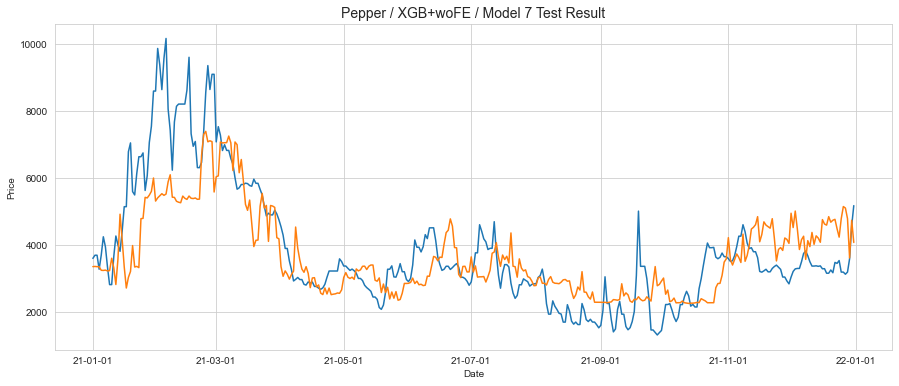

MAPE=24.337176188949627
RMSE=1195.2974179835596



Model30 Results



<Figure size 432x288 with 0 Axes>

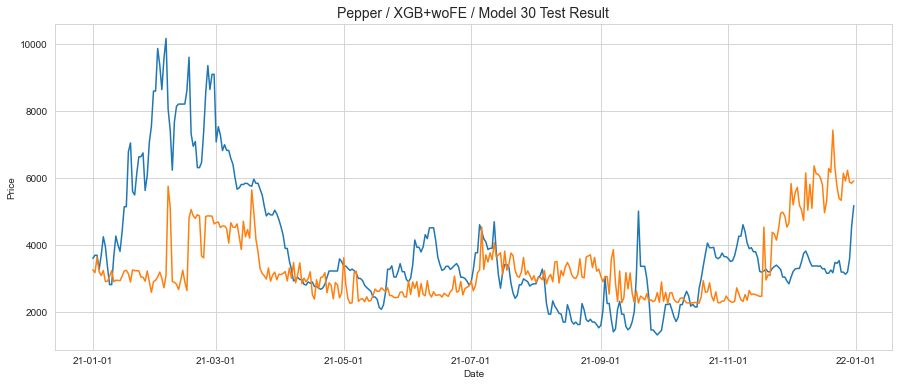

MAPE=35.8144882361152
RMSE=1915.4499513941273



Model60 Results



<Figure size 432x288 with 0 Axes>

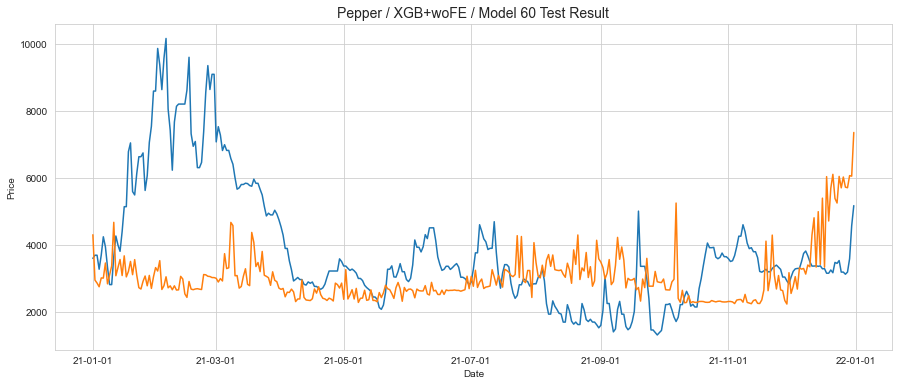

MAPE=38.66608856370317
RMSE=2129.460380423339



Model90 Results



<Figure size 432x288 with 0 Axes>

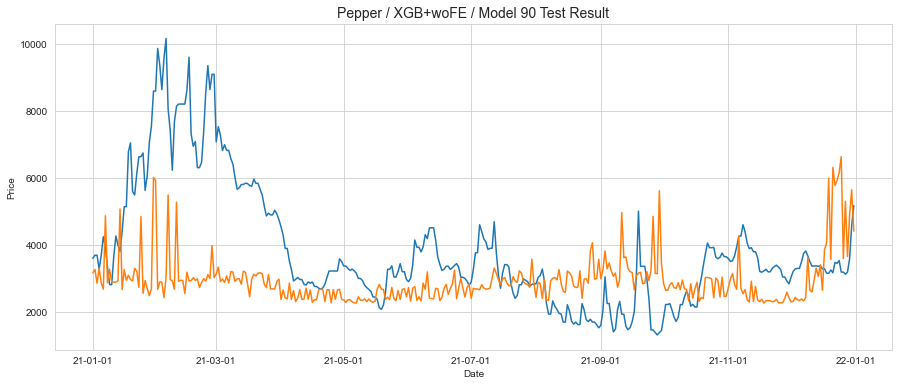

MAPE=37.52326011173061
RMSE=2069.8551809693267





<Figure size 432x288 with 0 Axes>

In [53]:
for i in range(0, NSEL):
    
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title(PDNAME + ' / ' + MDCODE + '+woFE / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')